## Store segmentation by Product Sales Using Amazon SageMaker

A chain of convenience stores have a variety of products that sell at varying quantities throughout the country. Some of the products sales are perpetually low and need to be removed while some genre of products may sell better in certain locations. Store managers would like to have an idea of which stores to place new products that have not been sold before in locations that sales would perform well. Here is where store segmentation comes in. This study would classify products by overall category and cluster the stores that are more likely to sell certain categories better this would give store managers information on what new products can be sold at their stores that would perform well. <br>

Methods include:
1. PCA for dimension reduction 
2. Kmeans for clustering by unsupervised learning <br>

Workflow steps:
1. Loading the data from Amazon S3
2. Exploratory data analysis (EDA) - Data cleaning and exploration
3. Data modelling
4. Drawing conclusions from our modelling

In [59]:
# Install dependencies
import sys

#!{sys.executable} -m pip install smdebug
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install plotly
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install shap
#!{sys.executable} -m pip install bokeh
#!{sys.executable} -m pip install imageio

In [2]:
#pip install mxnet

## Step 1: Loading the data from Amazon S3

In [3]:
import os
import boto3
import io
import sagemaker

%matplotlib inline

import pandas as pd
import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use("ggplot")
import pickle, gzip, urllib, json
import csv

In [4]:
from sagemaker import get_execution_role

role = get_execution_role()

In [5]:
role

'arn:aws:iam::837860013848:role/service-role/AmazonSageMaker-ExecutionRole-20220319T102415'

In [6]:
s3_client = boto3.client("s3")
data_bucket_name = "aws-ml-blog-sagemaker-store-segmentation"

In [7]:
obj_list = s3_client.list_objects(Bucket=data_bucket_name)
file = []
for contents in obj_list["Contents"]:
    file.append(contents["Key"])
print(file)

['store_sales.csv']


In [8]:
file_data = file[0]

In [9]:
response = s3_client.get_object(Bucket=data_bucket_name, Key=file_data)
response_body = response["Body"].read()
stores = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)

In [10]:
stores.head()

,store_num,10.Alcoholic Beverages,12.Cigarettes,13.Cold Dispensed Bevs,14.Confectionery,15.Dairy,17.Food Service,18.Frozen Food,19.Frozen Treats,20.Non-Foods,21.Packaged Foods,22.Health & Beauty Care,23.Hot Beverages,24.Non-Alcoholic Beverages,29.Refrigerated Food Products,30.Snacks,32.Tobacco
0,35694,1741,1999,1136,2460,378,5784,107,243,131,241,332,463,7326,111,2847,1736
1,35351,650,5054,1773,3363,950,9420,120,399,290,484,701,1250,10971,191,4322,2766
2,37297,1760,3641,1429,1829,485,6321,223,231,146,165,487,1213,8583,190,2641,2488
3,32648,1507,2926,886,1195,404,6060,182,373,173,156,306,939,5837,109,1637,1792
4,34197,3535,2839,1020,1679,259,4785,107,396,256,382,723,1116,7696,162,2901,3021


## Step 2: Exploratory data analysis EDA - Data cleaning and exploration

In [11]:
stores.shape

(232, 17)

In [12]:
# dropping all rows with nan as values
stores.dropna(inplace=True)
stores.shape

(232, 17)

In [13]:
stores.index = stores["store_num"]
stores.head()
drop = ["store_num"]

In [14]:
stores.head()

,store_num,10.Alcoholic Beverages,12.Cigarettes,13.Cold Dispensed Bevs,14.Confectionery,15.Dairy,17.Food Service,18.Frozen Food,19.Frozen Treats,20.Non-Foods,21.Packaged Foods,22.Health & Beauty Care,23.Hot Beverages,24.Non-Alcoholic Beverages,29.Refrigerated Food Products,30.Snacks,32.Tobacco
store_num,,,,,,,,,,,,,,,,,
35694,35694,1741,1999,1136,2460,378,5784,107,243,131,241,332,463,7326,111,2847,1736
35351,35351,650,5054,1773,3363,950,9420,120,399,290,484,701,1250,10971,191,4322,2766
37297,37297,1760,3641,1429,1829,485,6321,223,231,146,165,487,1213,8583,190,2641,2488
32648,32648,1507,2926,886,1195,404,6060,182,373,173,156,306,939,5837,109,1637,1792
34197,34197,3535,2839,1020,1679,259,4785,107,396,256,382,723,1116,7696,162,2901,3021


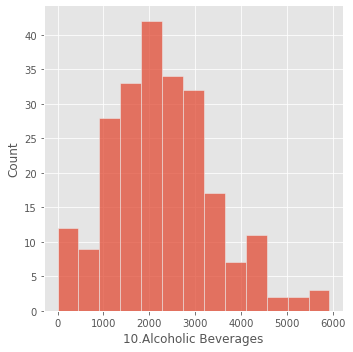

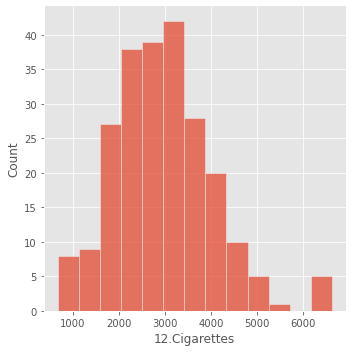

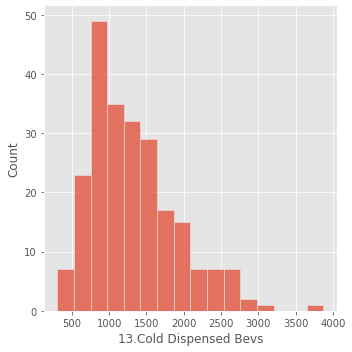

In [16]:
import seaborn as sns

for a in ["10.Alcoholic Beverages", "12.Cigarettes", "13.Cold Dispensed Bevs"]:
    #ax = plt.subplots(figsize=(6, 3))
    ax = sns.displot(stores[a])
    title = "Histogram of " + a
    #ax.set_title(title, fontsize=12)
    plt.show()

Data Scaling- We need to standardize the scaling of the numerical columns in order to use any distance based analytical methods so that we can compare the relative distances between different feature columns. We can use minmaxscaler to transform the numerical columns so that they also fall between 0 and 1.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
stores_scaled = pd.DataFrame(scaler.fit_transform(stores))
stores_scaled.columns = stores.columns
stores_scaled.index = stores.index

In [18]:
stores_scaled.describe()

,store_num,10.Alcoholic Beverages,12.Cigarettes,13.Cold Dispensed Bevs,14.Confectionery,15.Dairy,17.Food Service,18.Frozen Food,19.Frozen Treats,20.Non-Foods,21.Packaged Foods,22.Health & Beauty Care,23.Hot Beverages,24.Non-Alcoholic Beverages,29.Refrigerated Food Products,30.Snacks,32.Tobacco
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,0.808854,0.385035,0.385937,0.285942,0.412458,0.386437,0.258870,0.256036,0.293561,0.193876,0.223592,0.208558,0.210181,0.402932,0.322696,0.424364,0.241286
std,0.147407,0.193797,0.181344,0.165629,0.193722,0.185131,0.173089,0.164114,0.173431,0.130485,0.140960,0.113513,0.153008,0.198742,0.179287,0.191432,0.137995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.770584,0.254434,0.250547,0.161550,0.263452,0.246313,0.137018,0.147742,0.167347,0.112461,0.131332,0.141034,0.103925,0.256169,0.194712,0.301774,0.150832
50%,0.797427,0.370270,0.370854,0.252593,0.406860,0.350691,0.218826,0.227729,0.264286,0.168563,0.188555,0.193682,0.176902,0.383112,0.294471,0.409197,0.213763
75%,0.894646,0.492863,0.489392,0.364522,0.534377,0.525115,0.332899,0.314931,0.388010,0.240951,0.273218,0.251595,0.271720,0.540038,0.420673,0.540888,0.314760
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Step 3: Data modelling

In [19]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
print(bucket)

sagemaker-us-east-1-837860013848


In [20]:
from sagemaker import PCA

num_components = 12

pca_SM = PCA(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/stores/",
    num_components=num_components,
)

In [21]:
train_data = stores_scaled.values.astype("float32")

In [22]:
%%time
pca_SM.fit(pca_SM.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-20 21:37:34 Starting - Starting the training job...
2022-03-20 21:37:59 Starting - Preparing the instances for trainingProfilerReport-1647812254: InProgress
.........
2022-03-20 21:39:31 Downloading - Downloading input data.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/20/2022 21:40:22 INFO 140325360961344 integration.py:636] worker started
[03/20/2022 21:40:22 INFO 140325360961344] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[03/20/2022 21:40:22 INFO 140325360961344] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '17', 'mini_batch_size': '232', 'num_components': '12'}
[03/20/2022 21:40:22 

In [24]:
job_name = pca_SM.latest_training_job.name
model_key = "stores/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

In [25]:
import mxnet as mx

pca_model_params = mx.ndarray.load("model_algo-1")

Three groups of model parameters are contained within the PCA model.

mean is optional and is only available if the “subtract_mean” hyperparameter is true when calling the training step from the original PCA SageMaker function.

v  - contains the principal components (same as ‘components_’ in the sklearn PCA model).

s  - the singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

explained-variance-ratio ~= square(s) / sum(square(s))

To calculate the exact explained-variance-ratio vector if needed, it simply requires saving the sum of squares of the original data (call that N) and computing explained-variance-ratio = square(s) / N.

In [26]:
s = pd.DataFrame(pca_model_params["s"].asnumpy())
v = pd.DataFrame(pca_model_params["v"].asnumpy())

We can now calculate the variance explained by the largest n components that we want to keep. For this example, let's take the top 5 components.

We can see that the largest 5 components explain ~77% of the total variance in our dataset:

In [27]:
s.iloc[7:, :].apply(lambda x: x * x).sum() / s.apply(lambda x: x * x).sum()

0    0.774247
dtype: float32

After we have decided to keep the top 5 components, we can take only the 5 largest components from our original s and v matrix.

In [28]:
s_5 = s.iloc[7:, :]
v_5 = v.iloc[:, 7:]
v_5.columns = [0, 1, 2, 3, 4]

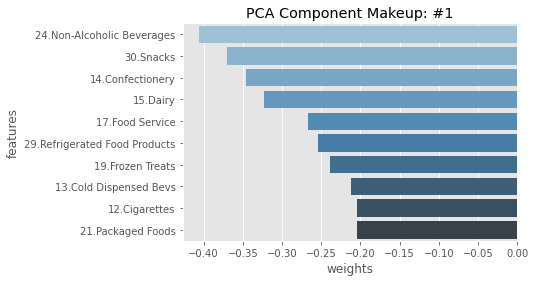

In [29]:
component_num = 1

first_comp = v_5[5 - component_num]
comps = pd.DataFrame(
    list(zip(first_comp, stores_scaled.columns)), columns=["weights", "features"]
)
comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
ax = sns.barplot(
    data=comps.sort_values("abs_weights", ascending=False).head(10),
    x="weights",
    y="features",
    palette="Blues_d",
)
ax.set_title("PCA Component Makeup: #" + str(component_num))
plt.show()

In [30]:
PCA_list = ["comp_1", "comp_2", "comp_3"]

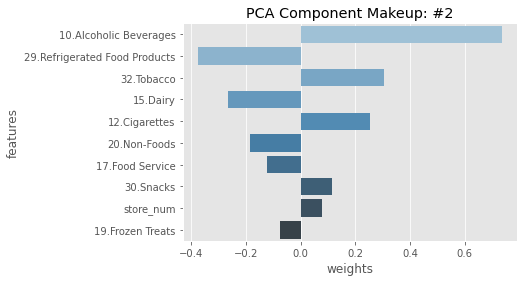

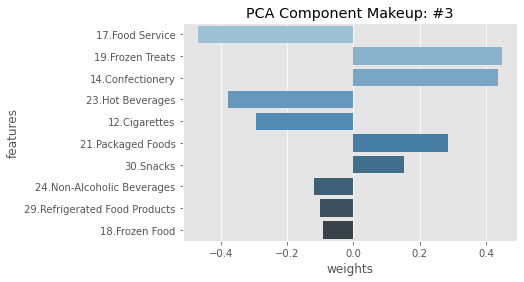

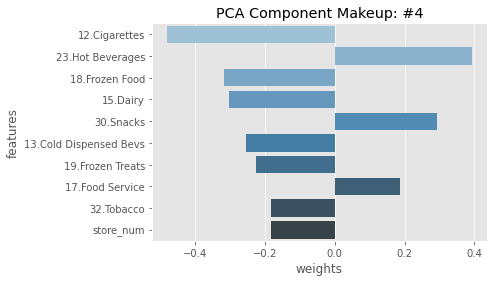

In [31]:
component_num = 2

for i in PCA_list:
    first_comp = v_5[5 - component_num]
    comps = pd.DataFrame(
        list(zip(first_comp, stores_scaled.columns)), columns=["weights", "features"]
    )
    comps["abs_weights"] = comps["weights"].apply(lambda x: np.abs(x))
    ax = sns.barplot(
        data=comps.sort_values("abs_weights", ascending=False).head(10),
        x="weights",
        y="features",
        palette="Blues_d",
    )
    ax.set_title("PCA Component Makeup: #" + str(component_num))
    plt.show()
    component_num = component_num+1

In [32]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!CPU times: user 184 ms, sys: 8.48 ms, total: 193 ms
Wall time: 5min 1s


In [35]:
%%time
result = pca_predictor.predict(train_data)

CPU times: user 20.8 ms, sys: 3.37 ms, total: 24.2 ms
Wall time: 177 ms


In [36]:
PCA_list = ["comp_1", "comp_2", "comp_3", "comp_4", "comp_5"]

In [37]:
stores_transformed = pd.DataFrame()
for a in result:
    b = a.label["projection"].float32_tensor.values
    stores_transformed = stores_transformed.append([list(b)])
stores_transformed.index = stores_scaled.index
stores_transformed = stores_transformed.iloc[:, 7:]
stores_transformed.columns = PCA_list

In [38]:
stores_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5
store_num,,,,,
35694,0.127237,0.028037,0.186221,-0.031350,0.327659
35351,0.062257,-0.197614,0.136682,-0.222220,-0.563237
37297,0.144425,-0.197572,-0.133326,-0.025704,0.152315
32648,-0.118093,-0.178635,-0.052778,-0.095616,0.532628
34197,0.022939,0.082699,0.112360,0.203223,0.185144


Now, we’ll use the KMeans algorithm to segment the store sales by the 5 PCA attributes we have created. KMeans is a clustering algorithm that identifies clusters of similar counties based on their attributes. Since we have ~232 stores and 16 attributes in our original dataset, the large feature space may have made it difficult to cluster the counties effectively. Instead, we have reduced the feature space to 5 PCA components, and we’ll cluster on this transformed dataset.

In [39]:
train_data = stores_transformed.values.astype("float32")

In [40]:
from sagemaker import KMeans

num_clusters = 5
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + bucket + "/stores/",
    k=num_clusters,
)

In [41]:
%%time
kmeans.fit(kmeans.record_set(train_data))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-03-20 21:49:04 Starting - Starting the training job...
2022-03-20 21:49:33 Starting - Preparing the instances for trainingProfilerReport-1647812944: InProgress
............
2022-03-20 21:51:30 Downloading - Downloading input data...
2022-03-20 21:51:55 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/20/2022 21:52:01 INFO 140022146594624 integration.py:636] worker started
[03/20/2022 21:52:01 INFO 140022146594624] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false'

In [42]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------!CPU times: user 162 ms, sys: 299 µs, total: 162 ms
Wall time: 4min 2s


In [43]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 225 ms


In [58]:
#result

In [45]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [46]:
pd.DataFrame(cluster_labels)[0].value_counts()

0.0    68
2.0    56
4.0    49
1.0    32
3.0    27
Name: 0, dtype: int64

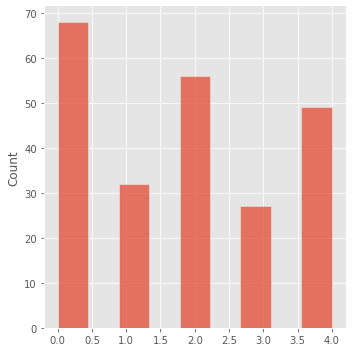

In [47]:
#ax = plt.subplots(figsize=(6, 3))
ax = sns.displot(cluster_labels, kde=False)
title = "Histogram of Cluster Counts"
#ax.set_title(title, fontsize=12)
plt.show()

## Step 4: Drawing conclusions from our modelling

 Accessing the KMeans model attributes

In [48]:
job_name = kmeans.latest_training_job.name
model_key = "stores/" + job_name + "/output/model.tar.gz"

boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
os.system("tar -zxvf model.tar.gz")

0

In [49]:
Kmeans_model_params = mx.ndarray.load("model_algo-1")

In [51]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = stores_transformed.columns

In [52]:
cluster_centroids

,comp_1,comp_2,comp_3,comp_4,comp_5
0,0.010377,-0.017335,0.023724,-0.037963,0.457816
1,-0.070833,0.035233,0.046659,0.250254,-0.280435
2,0.037532,-0.054437,-0.045180,-0.101859,-0.149196
3,0.059790,-0.101028,0.060960,-0.131923,-0.745937
4,-0.031757,0.116508,-0.054050,0.130278,0.131755


We can plot a heatmap of the centroids and their location in the transformed feature space. This gives us insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA plus clustering techniques together. Since we were able to examine the makeup of each PCA component, we can understand what each centroid represents in terms of the PCA components that we interpreted previously.

For example, we can see that cluster 0 has the highest value in the "Cigarettes & Hot beverages" attribute while it has the lowest value in the "Alcoholic beverages/Refrigerated Food Products" attribute compared with other clusters.

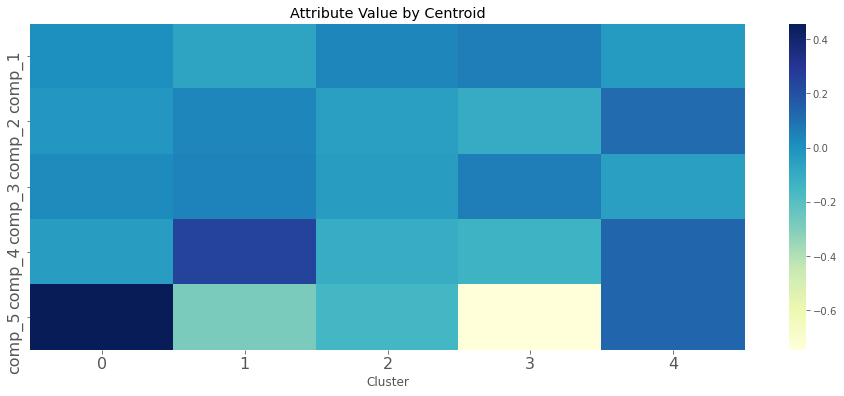

In [53]:
plt.figure(figsize=(16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap="YlGnBu")
ax.set_xlabel("Cluster")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [54]:
stores_transformed["labels"] = list(map(int, cluster_labels))
stores_transformed.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
store_num,,,,,,
35694,0.127237,0.028037,0.186221,-0.031350,0.327659,0
35351,0.062257,-0.197614,0.136682,-0.222220,-0.563237,3
37297,0.144425,-0.197572,-0.133326,-0.025704,0.152315,2
32648,-0.118093,-0.178635,-0.052778,-0.095616,0.532628,0
34197,0.022939,0.082699,0.112360,0.203223,0.185144,4


In [55]:
cluster = stores_transformed[stores_transformed["labels"] == 1]
cluster.head(5)

,comp_1,comp_2,comp_3,comp_4,comp_5,labels
store_num,,,,,,
33484,0.041247,0.059064,0.023924,0.282092,-0.070623,1
36499,0.029673,-0.189973,0.182867,0.078983,-0.274010,1
37210,0.086438,0.173937,-0.030023,0.372600,-0.094088,1
33264,-0.035569,0.065737,0.171699,0.450601,-0.071144,1
19969,-0.476131,0.193603,0.403274,0.092511,-0.127449,1


In [56]:
pca_predictor.delete_endpoint()

In [57]:
kmeans_predictor.delete_endpoint()